<a href="https://colab.research.google.com/github/princesharma74/sky-segmentation/blob/main/sky_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q wget
!pip install labelbox
!pip install -q segmentation_models_pytorch
!pip install ndjson

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/sky_segmentation/"
import os
os.listdir(BASE_DIR)

['custom_dataset', 'export-output.ndjson']

In [29]:
import os
import requests
from tqdm.notebook import tqdm
from google.colab import userdata

LB_API_KEY = userdata.get('LB_API_KEY')

CUSTOM_DIR = os.path.join(BASE_DIR, 'custom-dataset')

# Path to your NDJSON file
file_path = os.path.join(BASE_DIR, 'export-output.ndjson')
images_dir = os.path.join(BASE_DIR, 'custom_dataset/images')
masks_dir = os.path.join(BASE_DIR, 'custom_dataset/masks')

# Create directories if they don't exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

HEADERS = {
    'Authorization': f'Bearer {LB_API_KEY}',
}

def download_and_save(url, save_path, headers=None):
    try:
        if headers:
            response = requests.get(url, headers=headers, stream=True)
        else:
            response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for HTTP errors
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
    except requests.exceptions.RequestException as e:
        print(f"Request Error: {e}")

# Load data from NDJSON file
with open(file_path, 'r') as file:
    data = ndjson.load(file)

# Total number of items to download
total_items = len(data)

# Iterate through each item with a progress bar
for item in tqdm(data, desc='Processing items', total=total_items):
    # Save image
    image_url = item['data_row']['row_data']
    image_id = item['data_row']['id']
    image_save_path = os.path.join(images_dir, f"{image_id}.jpg")
    download_and_save(image_url, image_save_path)  # No headers passed for images

    # Save masks
    for project_id, project_data in item['projects'].items():
        for label in project_data['labels']:
            for annotation in label['annotations']['objects']:
                mask_url = annotation['mask']['url']
                mask_name = f"{image_id}_{annotation['name']}.jpg"
                mask_save_path = os.path.join(masks_dir, mask_name)
                download_and_save(mask_url, mask_save_path, headers=HEADERS)  # Headers passed for masks

print("Download completed.")

Processing items:   0%|          | 0/1275 [00:00<?, ?it/s]

Request Error: 520 Server Error:  for url: https://api.labelbox.com/api/v1/projects/ckctso3ye24q30855moxwvul5/annotations/ckcwc8ppy0fla0y97fmfl5gtf/mask
Request Error: 520 Server Error:  for url: https://api.labelbox.com/api/v1/projects/ckctso3ye24q30855moxwvul5/annotations/ckcxodjh600h60yau71q0fv0d/mask
Download completed.


In [30]:
custom_data_path = os.path.join(BASE_DIR, "custom_dataset")

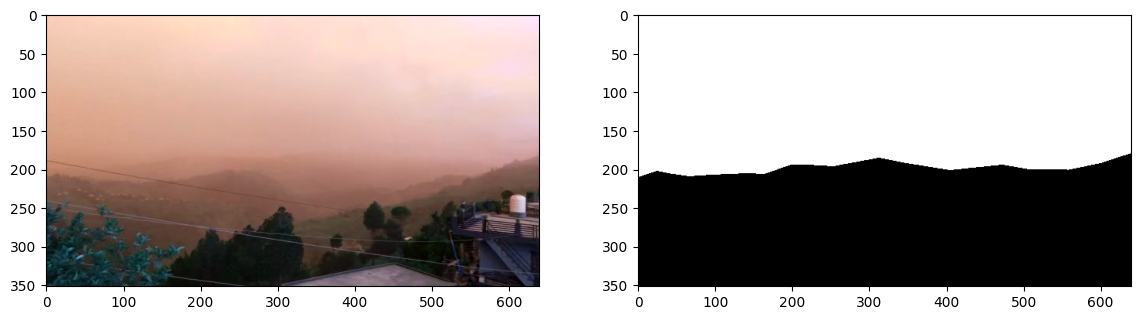

In [34]:
import cv2
import random
import matplotlib.pyplot as plt

images_path = os.path.join(custom_data_path, 'images')
masks_path = os.path.join(custom_data_path, 'masks')
images_list = [os.path.join(images_path, path) for path in os.listdir(images_path)]

idx = random.randint(0, len(images_list))
image_path = images_list[idx]
image = cv2.imread(image_path)

mask_paths = [os.path.join(masks_path, path) for path in os.listdir(masks_path) if image_path.split('/')[-1].split('.')[0] in path]
mask = cv2.imread(mask_paths[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
axes[0].imshow(image)
axes[1].imshow(mask)

In [ ]:
import torch
from torch.utils.data import Dataset

# test

class CustomDataset(Dataset):
  def __init__(self, images_list, masks_list, transform=None):
    self.path_list = [{ 'image' : image_path,
                        'mask' : {
                            path.split('_')[-1].split('.')[0] : path for path in masks_list if image_path.split('/')[-1].split('.')[0] in path
                        }} for image_path in images_list]

    self.transform = transform


  def __len__(self):
    return len(self.path_list)

  def __getitem__(self, idx):
    data = self.path_list[idx]
    org_image = cv2